## Predicting the polarity of a  word

* use a polarity lexicon with positive, negative and neutral words
* take 60% for training
* use word embeddings as features

* test traditional ML and MLP
* result SVM (non-linear support vector machine) and MLP are on par

* use grid search to optimize hyperparameter


* t-test comparing 2 ML approaches



* non-representative data harms
    * we learn a model with little neutral words
    * we test the model with twice as many neutral words
    * depending on the approach, accuracy drops by 4%
    
 
**NOTE: each run produces other results, the best ML approach might thus vary (the description in the test might be wrong, then** 

In [1]:
# get the fasttext embeddings 

#import torch
import numpy as np

def load_emb_from_file(filepath):

    word_to_index = {}
    embeddings = []
    with open(filepath, "r") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, embeddings

In [2]:
# index, array of word embeddings

widx,emb=load_emb_from_file("/home/klenner/Lehre/ml20/cc.de.300.vec")

In [3]:
import pandas as pd
from sklearn.utils import shuffle

# data of learning task: polarity lexicon for German
polex=pd.read_csv("/home/klenner/Lehre/ml20/polexNeutNomen",header=None,
                  index_col=[0,1],usecols=[0,1],names=['lemma', 'pol'])

#polex=pd.read_csv("/home/klenner/applications/jupyter/rnn-notebook/word_majority_label_ag.tsv",header=None,
#                  index_col=[0,1],usecols=[0,1],names=['lemma', 'pol'])

ids=[]     # gather all embedding indices
index={}   # map index to polarity
oov=0      # out of vocabolary counter
number_neut=0
index_neut=[]
max_neut=500

for (l,p),_ in polex.iterrows():  # (lemma,polarity) pairs
    try:
        id=widx[l]  
        if p=='POS' or p=='PRO':
            index[id]=1     # id is the word2vec index of lemma l
            ids.append(id)  # all ids for data split below
        elif p=='NEG' or p=='CON':
            index[id]=0
            ids.append(id)
        else:
            number_neut+=1
            if number_neut < max_neut:
                index[id]=2
                ids.append(id)
            else:
                index_neut.append(id)  # held out split of neutral nouns
    except:
        oov+=1
        pass

np.random.shuffle(ids)                    # random modifies ids directly
noun=[(id,index[id]) for id in ids]       # create input pairs: (word2vecID,polarity)

corpus_len=len(ids)
trainsplit= int(corpus_len*0.6)
                
# split in train and test
train=noun[:trainsplit]
test=noun[trainsplit+1:]

def distribution(set):
    pos=[1 for l,p in set if p == 1]
    neg=[1 for l,p in set if p == 0]
    neut=[1 for l,p in set if p == 2]
    all=len(set)

    return (len(pos)/all, len(neg)/all, len(neut)/all)


print("distribution train (pos,neg,neut)", distribution(train))
print("distribution test (pos,neg,neut)", distribution(test))

print("\n\nout of voc =",oov,"and additional neutrals =",len(index_neut))

distribution train (pos,neg,neut) (0.3076203833567087, 0.5535296867695184, 0.1388499298737728)
distribution test (pos,neg,neut) (0.31157894736842107, 0.5445614035087719, 0.14385964912280702)


out of voc = 322 and additional neutrals = 699


In [8]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score 
from sklearn.metrics import accuracy_score

from sklearn import tree

# create input for sklearn algorithms
X_train = [emb[index] for (index,_) in train]
y_train = [label for (_,label) in train]

# we add more neutral examples to the test set
# we thereby simulate the situtation that our training set was not representive
X_test_neut = [emb[index] for (index,_) in test]+[emb[index] for index in index_neut]
y_test_neut =  [label for (_,label) in test]+[2 for index in index_neut]

X_test = [emb[index] for (index,_) in test]
y_test =  [label for (_,label) in test]

def distribution_list(set):
    pos=[1 for p in set if p == 1]
    neg=[1 for p in set if p == 0]
    neut=[1 for p in set if p == 2]
    all=len(set)

    return (len(pos)/all, len(neg)/all, len(neut)/all)

print("distribution train (pos,neg,neut)", distribution(train))
print("distribution augmentet test (pos,neg,neut)", distribution_list(y_test_neut))

distribution train (pos,neg,neut) (0.3076203833567087, 0.5535296867695184, 0.1388499298737728)
distribution augmentet test (pos,neg,neut) (0.20903954802259886, 0.3653483992467043, 0.4256120527306968)


In [9]:
clf = tree.DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(X_train,y_train)

# result of a model learned from a non-representative is worse 

# apply it to the test set that has the same distribution as the training set
y_test_predict=clf.predict(X_test)
print("original neut\t", accuracy_score(y_test,y_test_predict))

y_test_predict_neut=clf.predict(X_test_neut)
print("additional neut\t",accuracy_score(y_test_neut,y_test_predict_neut))


precision_score(y_test,y_test_predict,average=None), recall_score(y_test,y_test_predict,average=None), f1_score(y_test,y_test_predict,average=None)

original neut	 0.7108771929824561
additional neut	 0.6793785310734464


(array([0.7790404 , 0.62186788, 0.63402062]),
 array([0.79510309, 0.61486486, 0.6       ]),
 array([0.7869898 , 0.61834655, 0.61654135]))

### Output format

             neg     pos        neut
prec: (array([0.75745785, 0.58719647, 0.60504202]),

~rec: array([0.7664042 , 0.59375   , 0.57142857]),

~ ~f1: array([0.76190476, 0.59045505, 0.5877551 ]))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train,y_train)

y_test_predict=neigh.predict(X_test)

print(accuracy_score(y_test,y_test_predict))
precision_score(y_test,y_test_predict,average=None), recall_score(y_test,y_test_predict,average=None), f1_score(y_test,y_test_predict,average=None)


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1000.0, solver= 'liblinear', random_state=0,multi_class='auto')
clf.fit(X_train, y_train)

y_test_predict=clf.predict(X_test)

print(accuracy_score(y_test,y_test_predict))
precision_score(y_test,y_test_predict,average=None), recall_score(y_test,y_test_predict,average=None), f1_score(y_test,y_test_predict,average=None)


In [12]:
clf = tree.DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(X_train,y_train)

# result of a model learned from a non-representative is worse 
y_test_predict=clf.predict(X_test)
print(accuracy_score(y_test,y_test_predict))

precision_score(y_test,y_test_predict,average=None), recall_score(y_test,y_test_predict,average=None), f1_score(y_test,y_test_predict,average=None)

tp_dec=[int(y_test[i]==y_test_predict[i]) for i in range(0,len(y_test))]

0.72


In [13]:
from sklearn.linear_model import Perceptron

clf = Perceptron(tol=1e-3)

clf.fit(X_train, y_train)

y_test_predict=clf.predict(X_test)

print(accuracy_score(y_test,y_test_predict))
precision_score(y_test,y_test_predict,average=None), recall_score(y_test,y_test_predict,average=None), f1_score(y_test,y_test_predict,average=None)

# 1 if prediction is right, 0 otherwise
# true positive dec
tp_perceptron=[int(y_test[i]==y_test_predict[i]) for i in range(0,len(y_test))]

0.888421052631579


In [14]:
from sklearn import svm

clf2 = svm.SVC(kernel='linear', C=1.0, random_state=0)

clf2.fit(X_train,y_train)

y_test_predict=clf2.predict(X_test)

print(accuracy_score(y_test, y_test_predict))
# precision_score(y_test,y_test_predict,average=None), recall_score(y_test,y_test_predict,average=None), f1_score(y_test,y_test_predict,average=None)

# true positive svm
tp_svm=[int(y_test[i]==y_test_predict[i]) for i in range(0,len(y_test))]

0.9143859649122807


In [16]:
# statistically significant differance between svm and decicison tree??
#
# t-test (one-sided, subtract lower from higher, thus look at the right side of the normal distribution)
#
# determine t_value from mean of differences/standard deviation
# null hypothesis: no difference

from scipy.stats import t
# pairwise difference of svm and dec
diff=np.array([tp_svm[i]-tp_dec[i] for i in range(0,len(y_test))])

df=len(y_test)-1

mean=np.mean(diff)
std=np.std(diff,ddof=1)

print("99% of values are below",t.ppf(0.99,df-1)) 

diff = np.array(tp_svm)-np.array(tp_dec)

t_val=mean/(std/np.sqrt(len(y_test)))

print("\n",t_val,"is clearly higher than it; rejection of null hypothesis, i.e. svm is sign. better")

99% of values are below 2.3289712732415597

 15.309129340992792 is clearly higher than it; rejection of null hypothesis, i.e. svm is sign. better


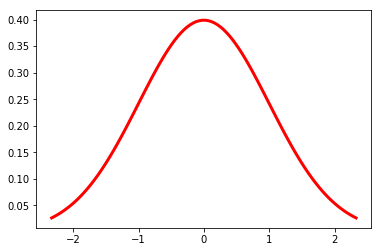

In [17]:
from scipy.stats import t
import matplotlib.pyplot as plt


x = np.linspace(t.ppf(0.01, df),t.ppf(0.99, df), 100)
plt.plot(x, t.pdf(x, df), 'r-', lw=3)


plt.show()

In [18]:
# statistically significant difference between svm  perceptron??
#
# t-test (one-sided, subtract lower from higher, thus look at the right side of the normal distribution)

# pairwise difference of svm and perceptron
diff=np.array([tp_svm[i]-tp_perceptron[i] for i in range(0,len(y_test))])

df=len(y_test)-1

mean=np.mean(diff)
std=np.std(diff,ddof=1)

print("99% (97.5%) of values are below", t.ppf(0.99,df-1),(t.ppf(0.975,df-1)))

#diff = np.array(tp_svm)-np.array(tp_dec)

t_val=mean/(std/np.sqrt(len(y_test)))

print("\nt_val",t_val,"is lower 99%; no rejection at alpha=1%, but higher 97.5% thus rejection at alpha=2.5%")

99% (97.5%) of values are below 2.3289712732415597 1.9616324708209134

t_val 3.348107823525538 is lower 99%; no rejection at alpha=1%, but higher 97.5% thus rejection at alpha=2.5%


In [10]:
from sklearn import svm

clf4 = svm.SVC(kernel='rbf', random_state=0, gamma=0.10, C=10.0)

clf4.fit(X_train,y_train)

#precision_score(y_test,y_test_predict,average=None), recall_score(y_test,y_test_predict,average=None), f1_score(y_test,y_test_predict,average=None)

y_test_predict_neut=clf4.predict(X_test_neut)
print("additional neut\t",accuracy_score(y_test_neut,y_test_predict_neut))
y_test_predict=clf4.predict(X_test)
print("original neut\t", accuracy_score(y_test,y_test_predict))

additional neut	 0.8935969868173258
original neut	 0.9157894736842105


In [11]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5, activation='relu',
                    hidden_layer_sizes=(300,10), random_state=1,validation_fraction=0.2,early_stopping=False)
                  
clf.fit(X_train, y_train)

y_test_predict=clf.predict(X_test)

print(precision_score(y_test,y_test_predict,average=None), recall_score(y_test,y_test_predict,average=None), f1_score(y_test,y_test_predict,average=None))

y_test_predict_neut=clf.predict(X_test_neut)
print("additional neut\t",accuracy_score(y_test_neut,y_test_predict_neut))
y_test_predict=clf.predict(X_test)
print("original neut\t", accuracy_score(y_test,y_test_predict))


[0.92875318 0.86425339 0.88832487] [0.94072165 0.86036036 0.85365854] [0.9346991  0.86230248 0.87064677]
additional neut	 0.885593220338983
original neut	 0.9031578947368422


In [5]:
from sklearn.linear_model import SGDClassifier
#sgd=SGDClassifier(random_state=42, max_iter=5)
sgd=SGDClassifier(random_state=42,loss='log', alpha=0.01,max_iter=5)

sgd.fit(X_train,y_train)

y_test_predict=sgd.predict(X_test)

print(precision_score(y_test,y_test_predict,average=None), recall_score(y_test,y_test_predict,average=None), f1_score(y_test,y_test_predict,average=None))
accuracy_score(y_test,y_test_predict)

[0.55035461 0.8        0.8       ] [1.         0.01801802 0.0195122 ] [0.70997255 0.03524229 0.03809524]


0.5529824561403509

In [6]:
# search the hyperparameter of a ML approach for the optimal combination

from sklearn.model_selection import GridSearchCV

def svc_param_selection(X, y, nfolds):
    loss= ['hinge', 'log', 'modified_huber','squared_hinge', 'perceptron']
    alpha=[0.5,0.1,0.01,0.001,0.0001]
    maxiter=[1,4,5,10,11,12,15,20]
    param_grid = {'loss': loss,'alpha':alpha,'max_iter':maxiter}
    grid_search = GridSearchCV(sgd, param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

p=svc_param_selection(X_train,y_train,5)
p

{'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 20}

In [7]:
sgd=SGDClassifier(random_state=42,loss='hinge', alpha=0.0001,max_iter=20)

sgd.fit(X_train,y_train)

y_test_predict=sgd.predict(X_test)

accuracy_score(y_test,y_test_predict)

0.9171929824561403

In [ ]:
from sklearn.model_selection import GridSearchCV

def svc_param_selection(X, y, nfolds):
    activation= ['tanh','relu']
    alpha=[0.5,0.1,0.01,0.001,0.0001]
    solver=['lbfgs', 'sgd', 'adam']
    early_stopping=[False,True]
    param_grid = {'activation': activation,'alpha':alpha,'solver':solver,'early_stopping':early_stopping}
    grid_search = GridSearchCV(clf, param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

p=svc_param_selection(X_train,y_train,5)
p

In [ ]:
def svc_param_selection(X, y, nfolds):
    hidden_layer_sizes=[(200,10),(300,10),(200,50),(300,100),(200,100)]
    activation= ['relu']
    solver=['adam']
    alpha=[0.1]
    early_stopping=[True]
    param_grid = {'hidden_layer_sizes':hidden_layer_sizes,'activation': activation,'alpha':alpha,'solver':solver,'early_stopping':early_stopping}
    grid_search = GridSearchCV(clf, param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

p=svc_param_selection(X_train,y_train,5)
p

In [23]:
# optimized settings

mlp = MLPClassifier(solver='adam', alpha=1e-5, activation='relu',
                    hidden_layer_sizes=(300,10), random_state=1,validation_fraction=0.2,early_stopping=True)
                  
mlp.fit(X_train, y_train)

y_test_predict=clf.predict(X_test)

print(precision_score(y_test,y_test_predict,average=None), recall_score(y_test,y_test_predict,average=None), f1_score(y_test,y_test_predict,average=None))

accuracy_score(y_test,y_test_predict)

[0.92546584 0.89411765 0.93333333] [0.96005155 0.85585586 0.88780488] [0.94244149 0.87456847 0.91      ]


0.9171929824561403